# DRIVE SAFE IN GENEVA


## Table of Contents

<p><div class="lev1"> <a href='#1Project_planning'><span class="toc-item-num">1.&nbsp;&nbsp;</span>Project planning</a> </div> 
<div class="lev1"><a href='#2Dataset_description'><span class="toc-item-num">2.&nbsp;&nbsp;</span>Dataset description</a></div> 
<div class="lev1"><a href='#3Understand_data'><span class="toc-item-num">3.&nbsp;&nbsp;</span>Understand the data</a></div> 
<div class="lev1"><a href='#31Libraries'><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Libraries import and dataset load</a></div>
<div class="lev1"><a href='#32Feature'><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature subgroup exploration</a></div>
<div class="lev1"><a href='#321Time'><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Time</a></div>
<div class="lev1"><a href='#322Localisation'><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Localisation</a></div>
<div class="lev1"><a href='#323Conditions'><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Conditions</a></div>
<div class="lev1"><a href='#324Accident'><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Accident type</a></div>
</p>

# 1. Project planning

<a id='1Project_planning'></a>
**Week 1** (1st nov - 8th Nov) : Understand the data

- Missing values
- Change the data formats
- Understand the categorical data
- Find distributions
- Correlations between the different features
- Find patterns
- Check for errors/dubious data

** Week 2 ** (9th - 16th nov)  Enrich the dataset

1. Search for external dataset that could further complete our dataset
2. Understand the new data
3. Transform this data
4. Merge with the global dataset
5. Relate adress, road and geolocalisation of our datasets
6. Begin exploratory analysis

# 2. Dataset description

<a id='2Dataset_description'></a>

# 3. Understand the data
<a id='3Understand_data'></a>

## 3.1. Libraries import and  dataset load
<a id='31Libraries'></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import folium

from pyproj import Proj, transform

from datetime import datetime
from datetime import date, time
from dateutil.parser import parse

In [20]:
# Read the dataset
acc_data = '../data_/OTC_ACCIDENTS.csv'
compt_trafic_data = '../data_/OTC_COMPTAGE_TRAFIC.csv'
acc_df = pd.read_csv(acc_data, sep=';', encoding='latin-1')
compt_trafic_df = pd.read_csv(compt_trafic_data, sep=';', encoding='latin-1')

FileNotFoundError: File b'../data_/OTC_ACCIDENTS.csv' does not exist

In [ ]:
# Show the df to have a better idea
acc_df.head(3)

In [ ]:
# Shape of the dataset
acc_df.shape

In [ ]:
# Information of the dataset
acc_df.info()

The Geneva accidents dataset has 19'231 datapoints with 35 different features. They can be grouped in the following feature subgroups:

1) **Time**: DATE_, HEURE, JOUR

2) **Localisation**: COMMUNE, COOR_X, COOR_Y, LOCALITE, E, N 

3) **Conditions**: CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

4) **Accident type**: GROUPE_ACCIDENT, CAUSE 

5) **Number and type of people**: NB_ENFANTS_IMPLIQUES, NB_ENFANTS_ECOLE, NB_BLESSES_LEGERS, NB_BLESSES_GRAVES, NB_TUES, NB_PIETONS  

6) **Number of vehicles involved**: NB_BICYCLETTES, NB_VAE_25, NB_VAE_45, NB_CYCLOMOTEURS, NB_MOTOS_50, NB_MOTOS_125, NB_MOTOS_11KW, NB_VOITURES_TOURISME, NB_VOITURES_LIVRAISON, NB_CAMIONS, NB_BUS, NB_TRAM


## 3.2 Feature subgroup exploration
<a id='32Feature'></a>

#### Plot helper functions


In [3]:
# Plot helper functions
def value_barplot_label(plot_name):
    # Inserts the value label on the top of each bar.

    for p in plot_name.patches:
        height = p.get_height()
        plot_name.text(p.get_x()+p.get_width()/2., height,'{:0.0f}'.format(height), ha="center").set_weight('bold')

def tick_format(plot,tick_type):
    if tick_type == 1:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
            label.set_rotation(90) 
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 2:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
    
    if tick_type == 3:
        for label in plot.get_xticklabels():
            label.set_fontsize(16)
        for label in plot.get_yticklabels():
            label.set_fontsize(14)
            label.set_rotation(20)

### 3.2.1 Time
<a id='321Time'></a>

An important feature of the accidents datasets is the time: It answers the question when the accidents happen. This feature will be very useful for our further analysis. As time features, there are:
- Date
- Hour
- Day of the week

Let's check the format of this three features:

In [4]:
print(acc_df.DATE_.head(2))
print(acc_df.HEURE.head(2))
print(acc_df.JOUR.head(2))

NameError: name 'acc_df' is not defined

In order to use these features, we need to change the format. In addition, to enrich our analysis, we will create the `Year`, `Month` and `Day` of the month to find more correlations with the accidents:

In [5]:
# Datetime format
acc_df['DATE_'] = acc_df['DATE_'].apply(lambda d: pd.to_datetime(d))
acc_df['HEURE'] = acc_df['HEURE'].apply(lambda d: pd.to_datetime(d))

# Create new time features
acc_df['YEAR'] = [date.year for date in acc_df['DATE_']]
acc_df['MONTH'] = [date.month for date in acc_df['DATE_']]
acc_df['DAY'] = [date.day for date in acc_df['DATE_']]
acc_df['HEURE'] = acc_df['HEURE'].fillna(acc_df['HEURE'].iloc[0])  # Fillna with first value of the df (Error neglible)
#acc_df.info()

NameError: name 'acc_df' is not defined

Once the time data can be treated, we start our exploratory analysis by computing:
- Number of accidents per year
- Number of accidents per month
- Number of accidents per day of the month
- Number of accidents per weekday

NameError: name 'acc_df' is not defined

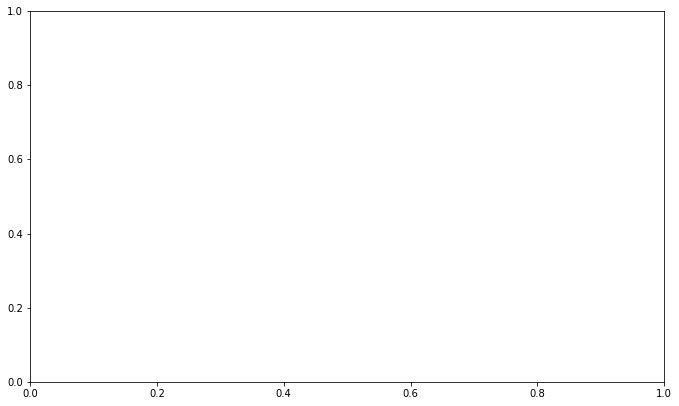

In [6]:
fig = plt.figure(figsize=(25,15))

# Visualize accidents per Year
ax1 = fig.add_subplot(221)
acc_per_year = acc_df.YEAR.value_counts(ascending=True, sort=False)
ax1 = sns.barplot(x=acc_per_year.index, 
                 y=acc_per_year, 
                 palette='Reds',
                 ax=ax1)
value_barplot_label(ax1)
plt.title("Accidents per year", fontsize=30).set_weight('bold')
tick_format(ax1, 2)
ax1.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax1.set_xlabel('Year', fontsize=16).set_weight('bold')


# Visualize accidents per month
ax2 = fig.add_subplot(222)
acc_per_month = acc_df.MONTH.value_counts(ascending=True, sort=False)
ax2 = sns.barplot(x=acc_per_month.index, 
                 y=acc_per_month, 
                 palette='Reds',
                 ax=ax2)
value_barplot_label(ax2)
plt.title("Accidents per month", fontsize=30).set_weight('bold')
tick_format(ax2, 2)
ax2.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax2.set_xlabel('Month', fontsize=16).set_weight('bold')

# Visualize accidents per day of the month
ax3 = fig.add_subplot(223)
acc_per_day = acc_df.DAY.value_counts(ascending=True, sort=False)
ax3 = sns.barplot(x=acc_per_day.index, 
                 y=acc_per_day, 
                 palette='Reds',
                 ax=ax3)
value_barplot_label(ax3)
plt.title("Accidents per day of the month", fontsize=30).set_weight('bold')
tick_format(ax3, 2)
ax3.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax3.set_xlabel('Day of the month', fontsize=16).set_weight('bold')

# Visualize accidents per weekday
ax4 = fig.add_subplot(224)
weekdays=['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
acc_per_weekday = acc_df.JOUR.value_counts(ascending=True, sort=False).reindex(weekdays)
ax4 = sns.barplot(x=acc_per_weekday.index, 
                 y=acc_per_weekday, 
                 palette='Reds',
                 ax=ax4)
value_barplot_label(ax4)
plt.title("Accidents per week day", fontsize=30).set_weight('bold')
tick_format(ax4, 2)
ax4.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax4.set_xlabel('Week day', fontsize=16).set_weight('bold')

From the plots above we can draw some first conclusions of the time features:
- There is an observable increase of number of accidents between 2011 to 2015. In 2016, there is a neglegible decrease.
- During the year, it can be observed some up-downs. There is a peak of accidents in March, June, September, October and November. Our first guess is that during the months when it is the holidays start or the end of the year months, it is more probable to have an accident. A further analysis could be done in order to verify the first assumption by getting the information of the year holidays and seeing the correlation with the accidents dates. (**TO DEVELOP**).
- During the month, there is no appreciable correlation within the day of the month and the probability to have an accident
- However, during the week, the days with higher probability to have an accident are Thurstday and Friday. A further analysis can be to see if there is an increase of this tendency during the years (**TO DEVELOP**)


**Create a new feature of time of the day (morning, afternoon, evening, night)**

### 3.2.2 Localisation
<a id='322Localisation'></a>

An other important question to ask is WHERE?. The localisation features will help to answer this question and find the relation with the other features. 
As localisation features, we can find:
- **COOR_X**: X coordenate in 'epsg_2056' reference system
- **COOR_Y**: X coordenate in 'epsg_2056' reference system

E and N gives the same information as COOR_X and COOR_Y. This is why they will be dropped. The COOR_X and COOR_Y coordenates will be projected in the GPS coordenates, also called 'epsg:4326' reference system. For this, the Proj and transform libraries will be used:

In [7]:
# projection definition
p1 = Proj(init='epsg:2056')
p2 = Proj(init='epsg:4326')

# Helper functions
def coord_proj(acc_df,i, p1, p2):
    x1 = acc_df['COOR_X'].loc[i]
    y1 = acc_df['COOR_Y'].loc[i]
    x2, y2 = transform(p1,p2,x1,y1)
    acc_df['COOR_X'].set_value(i, x2)
    acc_df['COOR_Y'].set_value(i, y2)
    return acc_df

In [8]:
# Project data
for i in range(0, len(acc_df['COOR_X'])-1):
    acc_df = coord_proj(acc_df,i, p1, p2)
# Delete unuseful columns
#del acc_df['N']
#del acc_df['E']
acc_df.head(3)

NameError: name 'acc_df' is not defined

An other localisation feature is the "Commune". In order more information to get insight of the accidents dataset, it will be interesting to have the number of inhabitants of each Commune (**TO Develop**)

In [9]:

plt.figure(figsize=(15,4))
commune_accidents = acc_df.COMMUNE.value_counts()
ax = sns.barplot(x=commune_accidents.index, 
                 y=commune_accidents, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(commune_accidents.index)))
ax.set(yticks=np.linspace(0,9000,num=10))
plt.title("Commune", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('# of accidents', fontsize=16).set_weight('bold')
ax.set_xlabel('Commune', fontsize=16).set_weight('bold')

NameError: name 'acc_df' is not defined

In [10]:
acc_df.LOCALITE.value_counts()

NameError: name 'acc_df' is not defined

### 3.2.3 Conditions
<a id='323Conditions'></a>

In this section the external conditions of eacha ccidetn will be analysed. In the list of external conditions we can find:
- Light conditions
- Weather conditions
- Road conditions
- Road type
CONDITIONS_LUMINEUSES, CONDITIONS_METEO, ETAT_ROUTE, GENRE_ROUTE

NameError: name 'acc_df' is not defined

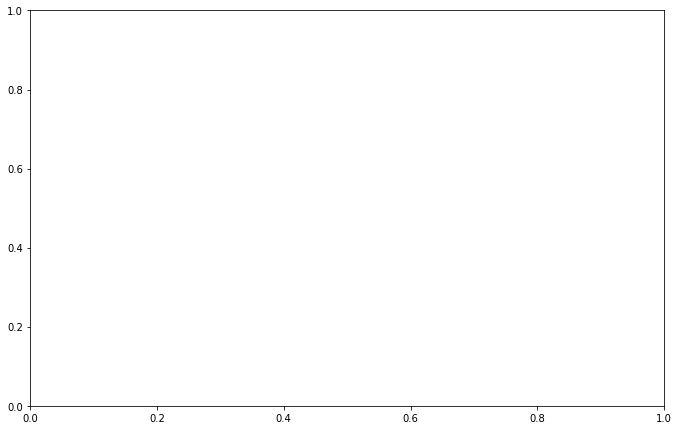

In [11]:
fig = plt.figure(figsize=(25,16))

# Visualize the accident group
ax1 = fig.add_subplot(221)
light_cond = acc_df.CONDITIONS_LUMINEUSES.value_counts()
ax1 = sns.barplot(x=light_cond, 
                 y=light_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(light_cond.index)),
                 ax=ax1)
plt.title("Light conditions", fontsize=30).set_weight('bold')
tick_format(ax1, 3)
ax1.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax1.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax2 = fig.add_subplot(222)
weather_cond = acc_df.CONDITIONS_METEO.value_counts()
ax2 = sns.barplot(x=weather_cond, 
                 y=weather_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(weather_cond.index)),
                 ax=ax2)
plt.title("Weather conditions", fontsize=30).set_weight('bold')
tick_format(ax2, 3)
ax2.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax3 = fig.add_subplot(223)
road_cond = acc_df.ETAT_ROUTE.value_counts()
ax3 = sns.barplot(x=road_cond, 
                 y=road_cond.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(road_cond.index)),
                 ax=ax3)
plt.title("Road conditions", fontsize=30).set_weight('bold')
tick_format(ax3, 3)
ax3.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax3.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

# Visualize the accident group
ax4 = fig.add_subplot(224)
road_type = acc_df.GENRE_ROUTE.value_counts()
ax4 = sns.barplot(x=road_type, 
                 y=road_type.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(road_type.index)),
                 ax=ax4)
plt.title("Type of road", fontsize=30).set_weight('bold')
tick_format(ax4, 3)
ax4.set_ylabel('Condition', fontsize=16).set_weight('bold')
ax4.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

### 3.2.4 Accident type
<a id='324Accident'></a>

In the accident type features, it can be found:
- Accident group
- Causes

Let's start analysing the accident group.

In [12]:
# Visualize the accident group
plt.figure(figsize=(15,10))
groupe_accidents = acc_df.GROUPE_ACCIDENT.value_counts()
ax = sns.barplot(x=groupe_accidents, 
                 y=groupe_accidents.index, 
                 palette=sns.cubehelix_palette(reverse=True, n_colors=len(groupe_accidents.index)))
ax.set(xticks=np.linspace(0,5500,num=12))
#value_barplot_label(ax)
plt.title("Accident Group", fontsize=30).set_weight('bold')
tick_format(ax, 1)
ax.set_ylabel('Accident group', fontsize=16).set_weight('bold')
ax.set_xlabel('# of accidents', fontsize=16).set_weight('bold')

NameError: name 'acc_df' is not defined

By the figure above, it can be identified that the accident groups with more accidents are:
- Dérapage ou perte de maîtrise
- Accident par tamponnement
- Accident en parquant

In [13]:
# Create a new df to treat the causes column
causes = acc_df[['CAUSE', 'GROUPE_ACCIDENT']]
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
del causes['GROUPE_ACCIDENT']

# Goal: To have only one "-" in order to split the causes into two columns, group and sugroup of causes
conflictive_txt = "(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)"
causes.CAUSE = causes.CAUSE.str.replace(conflictive_txt, "")
causes['count_'] = causes.CAUSE.apply(lambda x: x.count(' - '))
causes = causes.CAUSE.str.split(' - ', expand=True)
causes.rename(columns ={0: 'CAUSE_g', 1: 'CAUSE_sg'}, inplace=True)
acc_new = pd.concat([acc_df, causes], axis=1)
del acc_new['CAUSE']
acc_new.head(5)

NameError: name 'acc_df' is not defined

In [14]:
acc_new[acc_new.CAUSE_g == 'Inattention et distraction']


NameError: name 'acc_new' is not defined

Utilisation inadéquate du véhicule
    - Manoeuvres incorrectes dans le véhicule ():
        -(confusion frein - accélérateur, glisser de la pédale de frein dans les véhicules à transmission automatique, etc.)

In [15]:
# Create the map visualization
Geneve_coord = [46.2004013, 6.1531163]
m = folium.Map(location=Geneve_coord,
               tiles='OpenStreetMap',
               zoom_start=10)

In [16]:

for i in range(0, len(acc_df['COOR_X'].head(10))):
    folium.Marker([acc_df.COOR_Y.loc[i], acc_df.COOR_X.loc[i]] , popup="1").add_to(m)

NameError: name 'acc_df' is not defined

In [17]:
#acc_df[acc_df.COMMUNE == 'Genève'].COOR_Y

Ideas:
* For each accident zone personalize the information panels

In [18]:
m